# Project: NLP, Topic Modelling for Fraud detection on Enron emails

<br>

### Problem:
- Identify fraud cases from topic modelling on emails from the Enron case
- Identify a topic related to fraud and flag all text items (emails) with high probability for that topic as fraud using LDA

<br>

### Tools:
- Text Minning: tokenize,  remove stopwords, lemmatize words, stem words
- build dictionary and corpus with gensim
- Models: Latent Dirichlet Allocation
- Error Metrics: classification_report, confusion_matrix, r2_score, roc_auc_score 

<br>

### load defaults

In [15]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string

import myML_functions as myML_functions

# Import the lemmatizer from nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string

import gensim
from gensim import corpora
import pyLDAvis.gensim

from sklearn.metrics import classification_report, confusion_matrix, r2_score, roc_auc_score 

flag emails with some specif words as true fraud

In [3]:
df = pd.read_csv('./data/Fraud/chapter_4/enron_emails_clean.csv', keep_default_na=False)

searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']
df['flag'] = np.where((df['clean_content'].str.contains('|'.join(searchfor)) == True), 1, 0)

count = df['flag'].value_counts()
print(count)

0    1776
1     314
Name: flag, dtype: int64


## 1 - Topic modelling for Fraud detection
- without fraud labels: identify fraud topic by inspecting topics then flag all instance with high probability for this topic
- when fraud labels are known, find topics associated with fraud

**Tokenize and clean text**

In [4]:
lemma = WordNetLemmatizer()
porter= PorterStemmer()

# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent", "ect", "u", "fwd", "www", "com"))
# Define punctuations to exclude 
exclude = set(string.punctuation)

# Define word cleaning function
def clean(text, stop):   
    #remove punctuation, tokenization finished
    punc_free = [i for i in text if i not in exclude]
   
    #2 - Remove all stopwords 
    stop_free = [i for i in punc_free if((i not in stop) and (not i.isdigit()))]  
      
    #3 - Lemmatize words
    normalized = [lemma.lemmatize(i) for i in stop_free] 
    
    #4 - Stem words
    cleaned_text = [porter.stem(token) for token in normalized]
    
    return cleaned_text

# Clean the emails in df and print results
text_clean=[]
for text in df['clean_content']:   
    text = text.rstrip().lower().split()  
    text_clean.append(clean(text, stop))    

**Topic Modelling with LDA**

In [40]:
dictionary = corpora.Dictionary(text_clean)
dictionary.filter_extremes(no_below=5, keep_n=50000)
corpus = [dictionary.doc2bow(text) for text in text_clean]

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=5)
topics = ldamodel.print_topics(num_words=5)

for topic in topics:
    print(topic)

(0, '0.014*"pm" + 0.014*"messag" + 0.012*"origin" + 0.011*"thank" + 0.011*"hou"')
(1, '0.046*"imag" + 0.043*"td" + 0.031*"net" + 0.029*"money" + 0.028*"tr"')
(2, '0.011*"market" + 0.008*"compani" + 0.008*"time" + 0.007*"price" + 0.007*"servic"')
(3, '0.012*"compani" + 0.010*"employe" + 0.007*"energi" + 0.007*"million" + 0.007*"schedul"')


**Flag fraud based on topic inspection**

In [ ]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)

In [43]:
pyLDAvis.display(lda_display)

In [7]:
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df

In [52]:
contents = pd.DataFrame({'Original text': text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)

# Create flag for text highest associated with topic 3
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 3.0), 1, 0)
print(topic_details.head())

   Dominant_Topic   % Score  \
0             2.0  0.796452   
1             2.0  0.512478   
2             0.0  0.833935   
3             3.0  0.993045   
4             3.0  0.992929   

                                       Original text  flag  
0  [investool, advisori, free, digest, trust, inv...     0  
1  [forward, richard, b, sander, hou, pm, justin,...     0  
2  [hey, wear, target, purpl, shirt, today, mine,...     0  
3  [lesli, milosevich, santa, clara, avenu, alame...     1  
4  [rini, twait, e, th, ave, longmont, co, rtwait...     1  


R2: -0.582
Roc_Auc: 0.738

Classifcation report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87      1776
           1       0.40      0.65      0.49       314

   micro avg       0.80      0.80      0.80      2090
   macro avg       0.66      0.74      0.68      2090
weighted avg       0.85      0.80      0.82      2090

Confusion matrix, without normalization


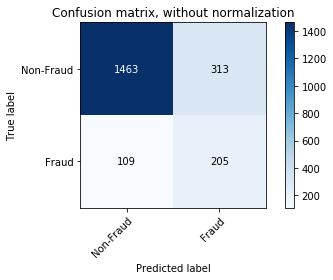

In [53]:
y_true = df['flag']
y_predict = topic_details['flag']

print(f"R2: {r2_score(y_true, y_predict):0.3f}")
print(f"Roc_Auc: {roc_auc_score(y_true, y_predict):0.3f}\n")

print('Classifcation report:\n', classification_report(y_true, y_predict))

class_names = np.array(['Non-Fraud', 'Fraud'])
myML_functions.plot_confusion_matrix(y_true, y_predict, classes=class_names)
plt.show()